# Wing Kinematics

In [1]:
#pip install pynamics

In [2]:
%matplotlib inline
import scipy.optimize
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
plt.ion()
from math import pi, sin, cos, tan, asin, acos, atan, degrees, radians

In [3]:
def prettyplot(x,y): # Function plots mechanism and generates labels
    # Create Figure
    Fig1 = plt.figure(figsize=[15,15])
    ax = Fig1.add_axes([0.0, 0.0, 1.0, 1.0], aspect='equal')
    
    # plot links and joints
    plt.plot(x[0:3],y[0:3],color='tab:blue')
    plt.plot(x[2:5],y[2:5],color='tab:green')
    plt.plot(x[4:],y[4:],color='k')
    plt.scatter(x,y,color='k')
    plt.axis('equal')
    plt.xlim([-10,120])
    
    # label joints
    for i in range(0, len(x)-1):
        plt.text(x[i]-1, y[i]-1, "p"+str(i), verticalalignment='top', horizontalalignment='right', fontsize=14)
    
    # plot COMs
    comx = [(x[0]+x[1])/2, (x[1]+x[2])/2, (x[4]+x[3])/2, (x[3]+x[2])/2, (x[4]+x[0])/2]
    comy = [(y[0]+y[1])/2, (y[1]+y[2])/2, (y[4]+y[3])/2, (y[3]+y[2])/2, (y[4]+y[0])/2]
    plt.scatter(comx,comy,color='k')
    
    # label COMs
    linknames = ['A', 'B', 'C', 'D', 'E']
    for i in range(0, len(comx)):
        plt.text(comx[i]+1, comy[i], linknames[i], verticalalignment='bottom', horizontalalignment='left', weight='bold', fontsize=16)
    
    # label properties
    propertynames = ['La', 'Lb', 'Lc', 'Ld', 'Le']
    for i in range(0, len(comx)):
        plt.text(comx[i]+4, comy[i], propertynames[i], verticalalignment='bottom', horizontalalignment='left', fontsize=14)
    
    
    # plot frame axes
    alen = 10    
    plt.arrow(0, 0, alen, 0,head_width=2,width=0.1,color='r')
    plt.arrow(0, 0, 0, alen,head_width=2,width=0.1,color='r')
    vx = []
    vy = []
    for i in range(1, len(x)-2):
        if i <= 2: 
            vecx = numpy.array([x[i]-x[i-1], y[i]-y[i-1]])
            vecx = vecx/(vecx.dot(vecx)**0.5)
            vecy = numpy.cross([0,0,1], vecx)[0:2]
            plt.arrow(x[i], y[i], alen*vecx[0], alen*vecx[1],head_width=2,width=0.1,color='b')
            plt.arrow(x[i], y[i], alen*vecy[0], alen*vecy[1],head_width=2,width=0.1,color='b')
            vx.append(vecx)
            vy.append(vecy)
        if i >= 2:
            vecx = numpy.array([x[i]-x[i+1], y[i]-y[i+1]])
            vecx = vecx/(vecx.dot(vecx)**0.5)
            vecy = numpy.cross([0,0,1], vecx)[0:2]
            plt.arrow(x[i], y[i], alen*vecx[0], alen*vecx[1],head_width=2,width=0.1,color='g')
            plt.arrow(x[i], y[i], alen*vecy[0], alen*vecy[1],head_width=2,width=0.1,color='g')
            vx.append(vecx)
            vy.append(vecy)

    # label frames
    lablen = 15

    plt.text(x[0]+15, y[0], 'Nx', verticalalignment='center', horizontalalignment='center', color='r', fontsize=14)
    plt.text(x[0], y[0]+15, 'Ny', verticalalignment='center', horizontalalignment='center', color='r', fontsize=14)
    
    plt.text(x[1]+lablen*vx[0][0], y[1]+lablen*vx[0][1], 'Ax', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)
    plt.text(x[1]+lablen*vy[0][0], y[1]+lablen*vy[0][1], 'Ay', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)

    plt.text(x[2]+lablen*vx[1][0], y[2]+lablen*vx[1][1], 'Bx', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)
    plt.text(x[2]+lablen*vy[1][0], y[2]+lablen*vy[1][1], 'By', verticalalignment='center', horizontalalignment='center', color='b', fontsize=14)

    plt.text(x[3]+lablen*vx[3][0], y[3]+lablen*vx[3][1], 'Cx', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)
    plt.text(x[3]+lablen*vy[3][0], y[3]+lablen*vy[3][1], 'Cy', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)

    plt.text(x[2]+lablen*vx[2][0], y[2]+lablen*vx[2][1], 'Dx', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)
    plt.text(x[2]+lablen*vy[2][0], y[2]+lablen*vy[2][1], 'Dy', verticalalignment='center', horizontalalignment='center', color='g', fontsize=14)

    # plot angles
    Aang1 = 0
    Aang2 = degrees(atan(vx[0][1]/vx[0][0]))
    ax.add_patch(Arc((0, 0), 10, 10, theta1=min(Aang1, Aang2), theta2=max(Aang1, Aang2), edgecolor='k', linewidth=1.5, label='q1'))

    Bang1 = degrees(atan(vx[0][1]/vx[0][0]))
    Bang2 = degrees(atan(vx[1][1]/vx[1][0]))
    ax.add_patch(Arc((x[1], y[1]), 10, 10, theta1=min(Bang1, Bang2), theta2=max(Bang1, Bang2), edgecolor='k', linewidth=1.5))

    plt.plot([0,10],[10,10],color='k',linewidth=1)
    Cang1 = 0
    Cang2 = degrees(atan(vx[3][1]/vx[3][0]))
    ax.add_patch(Arc((x[4], y[4]), 10, 10, theta1=min(Cang1, Cang2), theta2=max(Cang1, Cang2), edgecolor='k', linewidth=1.5))

    Dang1 = degrees(atan(vx[3][1]/vx[3][0]))
    Dang2 = degrees(atan(vx[2][1]/vx[2][0]))
    ax.add_patch(Arc((x[3], y[3]), 10, 10, theta1=min(Dang1, Dang2), theta2=max(Dang1, Dang2), edgecolor='k', linewidth=1.5))

    # label angles
    plt.text(x[0]+8*cos(radians((Aang1+Aang2)/2)), y[0]+8*sin(radians((Aang1+Aang2)/2)), 'qA', verticalalignment='center', horizontalalignment='center', fontsize=14)
    plt.text(x[1]+8*cos(radians((Bang1+Bang2)/2)), y[1]+8*sin(radians((Bang1+Bang2)/2)), 'qB', verticalalignment='center', horizontalalignment='center', fontsize=14)
    plt.text(x[4]+8*cos(radians((Cang1+Cang2)/2)), y[4]+8*sin(radians((Cang1+Cang2)/2)), 'qC', verticalalignment='center', horizontalalignment='center', fontsize=14)
    plt.text(x[3]+8*cos(radians((Dang1+Dang2)/2)), y[3]+8*sin(radians((Dang1+Dang2)/2)), 'qD', verticalalignment='center', horizontalalignment='center', fontsize=14)

## 1. Create a figure
Create a figure (either in python, in a vector-based drawing program like inkscape or illustrator, or as a solidworks rendering) of your system kinematics. Annotate the image to include:

- Names for each rotational reference frame. You will need one for each rigid body (that moves independently), as well as one for the Newtonian reference frame (N). Use the convention of a capital letter (A,B,C,…)
- Labeled joint locations
- A set of orthonormal basis vectors for each fram. It is best practice to align one of the basis vectors with each rigid link.
- variable names for each state variable 
- geometric constants such as link lengths

Save this figure for reuse later. You will need to add mass and inertial information as well as system stiffness information, so make sure you do your work in a way that permits reusing and modifying the figure.

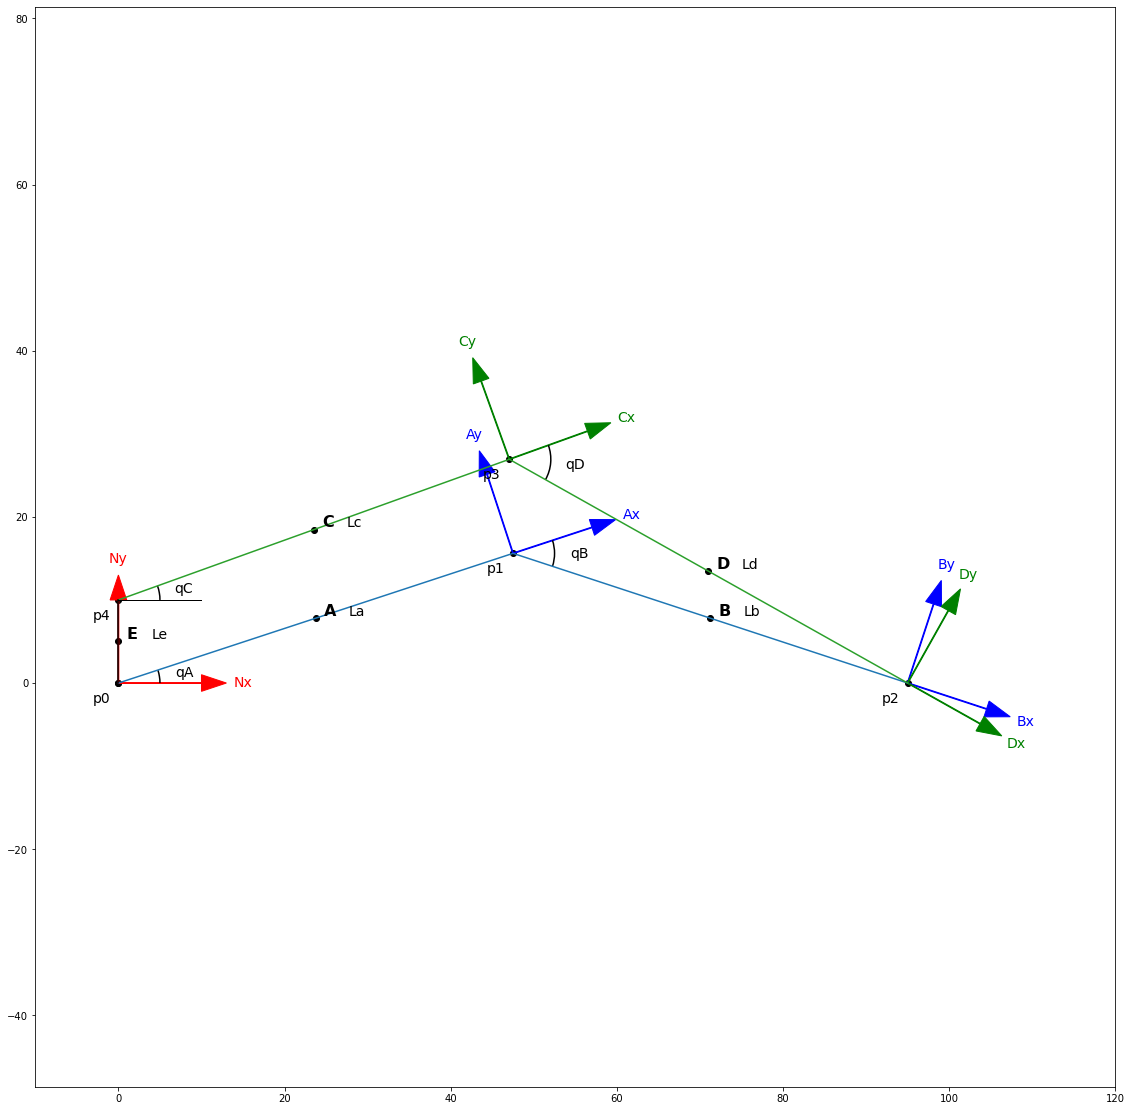

In [4]:
# Kinematics Demo Position
x = numpy.array([0, 47.5, 95, 47.05, 0, 0])
y = numpy.array([0, 15.61, 0, 26.93, 10, 0])
prettyplot(x,y)

## 2. Make the device in paper or cardboard. 
You need an up-to-date model if it has changed from your individual assignments. The paper model should dimensionally match your code.

![](https://github.com/biodegradablerobotics/biodegradablerobotics.github.io/blob/main/System%20Kinematics/paper%20wing%20reduce.jpeg?raw=1)

## 3. Develop a Kinematic Model

Using a pynamics-based script, develop a kinematic model for your device. Following the triple pendulum example,

1. Import packages

2. Define variables and constants (you may want to add, remove, or rename variables to match your figure)
    
3. Declare frames (you may need to add frames or rename them)

4. Define frame rotations (you may want to switch the axis about which frames rotate)

5. Compose kinematics (this depends entirely on the geometry of your system)

6. Take time-derivatives of position vectors

7. Assemble into a Jacobian that maps input velocities to output velocities.

In [5]:
# Create a pynamics system
system = System()
pynamics.set_system(__name__,system)

In [6]:
# Declare constants
lA_num = 0.05
lB_num = 0.05
lC_num = 0.055
lD_num = 0.05
lE_num = 0.01

lA = Constant(lA_num,'lA',system)
lB = Constant(lB_num,'lB',system)
lC = Constant(lC_num,'lC',system)
lD = Constant(lD_num,'lD',system)
lE = Constant(lE_num,'lE',system)

In [7]:
# Create differentiable state variables
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)

In [8]:
# initial values
# qC = 11.97 creates fully extended, horizontal wing
initialvalues = {}
initialvalues[qA]=0*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180

initialvalues[qC]=11.97*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=0*pi/180
initialvalues[qD_d]=0*pi/180

In [9]:
# Retrieve state variables in the order they are stored in the system
# Create a list of initial values ini0 in the order of the system’s state variables
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

In [10]:
# Create frames
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')
D = Frame('D')

In [11]:
# Declare N as the Newtonian (fixed) frame
system.set_newtonian(N)

In [12]:
# Rotate other frames about their local Z axes.
A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(N,[0,0,1],qC,system)
D.rotate_fixed_axis_directed(C,[0,0,1],qD,system)

In [13]:
# Define rigid body kinematics
# position vectors
p0 = 0*N.x #Normal
p1 = p0 + lA*A.x #Link A
p2A = p1 + lB*B.x #Link B - OUTPUT
p4 = p0 + lE*N.y #Link E
p3 = p4 + lC*C.x #Link C
p2C = p3 + lD*D.x #Link D - OUTPUT

In [14]:
# Declare a list of points that will be used for plotting
points = [p0, p1, p2A, p3, p4]

In [15]:
# Constraints
eq_vector = p2A-p2C
eq = []
eq.append((eq_vector).dot(N.x))
eq.append((eq_vector).dot(N.y))
eq_d=[(system.derivative(item)) for item in eq]

In [16]:
# Turn constraint equations into a vector
eq_d_sym = sympy.Matrix(eq_d)

In [17]:
# Turn qi and qd into sympy vectors
qi_sym = sympy.Matrix([qA_d, qC_d])
qd_sym = sympy.Matrix([qB_d, qD_d])

In [18]:
# Take partial derivative of constraints with respect to independent and dependent variables
AA = eq_d_sym.jacobian(qi_sym)
BB = eq_d_sym.jacobian(qd_sym)

In [19]:
# Solve for internal input/output Jacobian
Jin = -BB.inv()*AA
Jin.simplify()
Jin

⎡lA⋅sin(-qA + qC + qD)                                       ⎤
⎢────────────────────── - lB                                 ⎥
⎢sin(qA + qB - qC - qD)                 -lC⋅sin(qD)          ⎥
⎢───────────────────────────     ─────────────────────────   ⎥
⎢             lB                 lB⋅sin(qA + qB - qC - qD)   ⎥
⎢                                                            ⎥
⎢                              ⎛ lC⋅sin(qA + qB - qC)      ⎞ ⎥
⎢                             -⎜────────────────────── + lD⎟ ⎥
⎢         lA⋅sin(qB)           ⎝sin(qA + qB - qC - qD)     ⎠ ⎥
⎢ ─────────────────────────   ───────────────────────────────⎥
⎣ lD⋅sin(qA + qB - qC - qD)                  lD              ⎦

In [20]:
# Solving for the dependent variables 
qd2_sym = Jin*qi_sym
qd2_sym

⎡                                   ⎛lA⋅sin(-qA + qC + qD)      ⎞⎤
⎢                              qA_d⋅⎜────────────────────── - lB⎟⎥
⎢       lC⋅qC_d⋅sin(qD)             ⎝sin(qA + qB - qC - qD)     ⎠⎥
⎢- ───────────────────────── + ──────────────────────────────────⎥
⎢  lB⋅sin(qA + qB - qC - qD)                   lB                ⎥
⎢                                                                ⎥
⎢                                  ⎛ lC⋅sin(qA + qB - qC)      ⎞ ⎥
⎢                             qC_d⋅⎜────────────────────── + lD⎟ ⎥
⎢      lA⋅qA_d⋅sin(qB)             ⎝sin(qA + qB - qC - qD)     ⎠ ⎥
⎢ ───────────────────────── - ────────────────────────────────── ⎥
⎣ lD⋅sin(qA + qB - qC - qD)                   lD                 ⎦

In [21]:
# Substitution dictionary to replace all occurrances of qB_d and qD_d
subs_sym = dict([(ii,jj) for ii,jj in zip(qd_sym,qd2_sym)])
subs_sym

⎧                                         ⎛lA⋅sin(-qA + qC + qD)      ⎞       
⎪                                    qA_d⋅⎜────────────────────── - lB⎟       
⎨             lC⋅qC_d⋅sin(qD)             ⎝sin(qA + qB - qC - qD)     ⎠       
⎪qB_d: - ───────────────────────── + ──────────────────────────────────, qD_d:
⎩        lB⋅sin(qA + qB - qC - qD)                   lB                       

                                  ⎛ lC⋅sin(qA + qB - qC)      ⎞⎫
                             qC_d⋅⎜────────────────────── + lD⎟⎪
      lA⋅qA_d⋅sin(qB)             ⎝sin(qA + qB - qC - qD)     ⎠⎬
 ───────────────────────── - ──────────────────────────────────⎪
 lD⋅sin(qA + qB - qC - qD)                   lD                ⎭

In [22]:
# End effector position
pend = p2A
pend

lA*A.x + lB*B.x

In [23]:
# End effector velocity
vend = pend.time_derivative()
vend = vend.subs(subs_sym)
vend

lA*qA_d*A.y + lB*B.y*(qA_d - lC*qC_d*sin(qD)/(lB*sin(qA + qB - qC - qD)) + qA_d*(lA*sin(-qA + qC + qD)/sin(qA + qB - qC - qD) - lB)/lB)

In [24]:
# Turn end effector velocity equations into a vector
vend_sym = sympy.Matrix([vend.dot(N.x), vend.dot(N.y)])

In [25]:
# Take partial derivative of end effector velocities with respect to independent variables
J = vend_sym.jacobian(qi_sym)
J.simplify()
J

⎡-lA⋅sin(qB)⋅sin(qC + qD)    lC⋅sin(qD)⋅sin(qA + qB) ⎤
⎢─────────────────────────   ─────────────────────── ⎥
⎢  sin(qA + qB - qC - qD)     sin(qA + qB - qC - qD) ⎥
⎢                                                    ⎥
⎢ lA⋅sin(qB)⋅cos(qC + qD)   -lC⋅sin(qD)⋅cos(qA + qB) ⎥
⎢ ───────────────────────   ─────────────────────────⎥
⎣  sin(qA + qB - qC - qD)     sin(qA + qB - qC - qD) ⎦

## 4. Solve for an Initial Condition
   Select or Solve for a valid initial condition that represents the system in the middle of a typical gait, when it is both moving and when forces are being applied to it (or to the world by it)

   Despite the fact that you will be using a symbolic representation, you still need to solve for a valid initial condition if your device is a “parallel mechanism.” This may be done using a nonlinear solver such as scipy.optimize.minimize

In [26]:
# Identify independent and dependent variables
qi = [qA, qC]
qd = [qB, qD]

In [27]:
# Create a copy of symbolic constants dictionary and add the initial value of qi to it
constants = system.constant_values.copy()
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

In [28]:
# Substitute constants in equation
eq = [item.subs(constants) for item in eq]

In [29]:
# Convert to numpy array
# Sum the error
error = (numpy.array(eq)**2).sum()

In [30]:
# Convert to a function that scipy can use.
# Sympy has a “labmdify” function that evaluates an expression, but scipy needs a slightly different format.
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

In [31]:
# Take the derivative of the equations to linearize with regard to the velocity variables
guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)
if result.fun>1e-3:
    raise(Exception("out of tolerance"))
ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))
#points.plot_time()

2021-02-19 20:15:38,543 - pynamics.output - INFO - calculating outputs
2021-02-19 20:15:38,545 - pynamics.output - INFO - done calculating outputs


array([[[0.        , 0.        ],
        [0.05      , 0.        ],
        [0.1       , 0.        ],
        [0.0538041 , 0.02140697],
        [0.        , 0.01      ]],

       [[0.        , 0.        ],
        [0.05      , 0.        ],
        [0.09995767, 0.0020569 ],
        [0.0538041 , 0.02140697],
        [0.        , 0.01      ]]])

## 5. Plot the system in this position

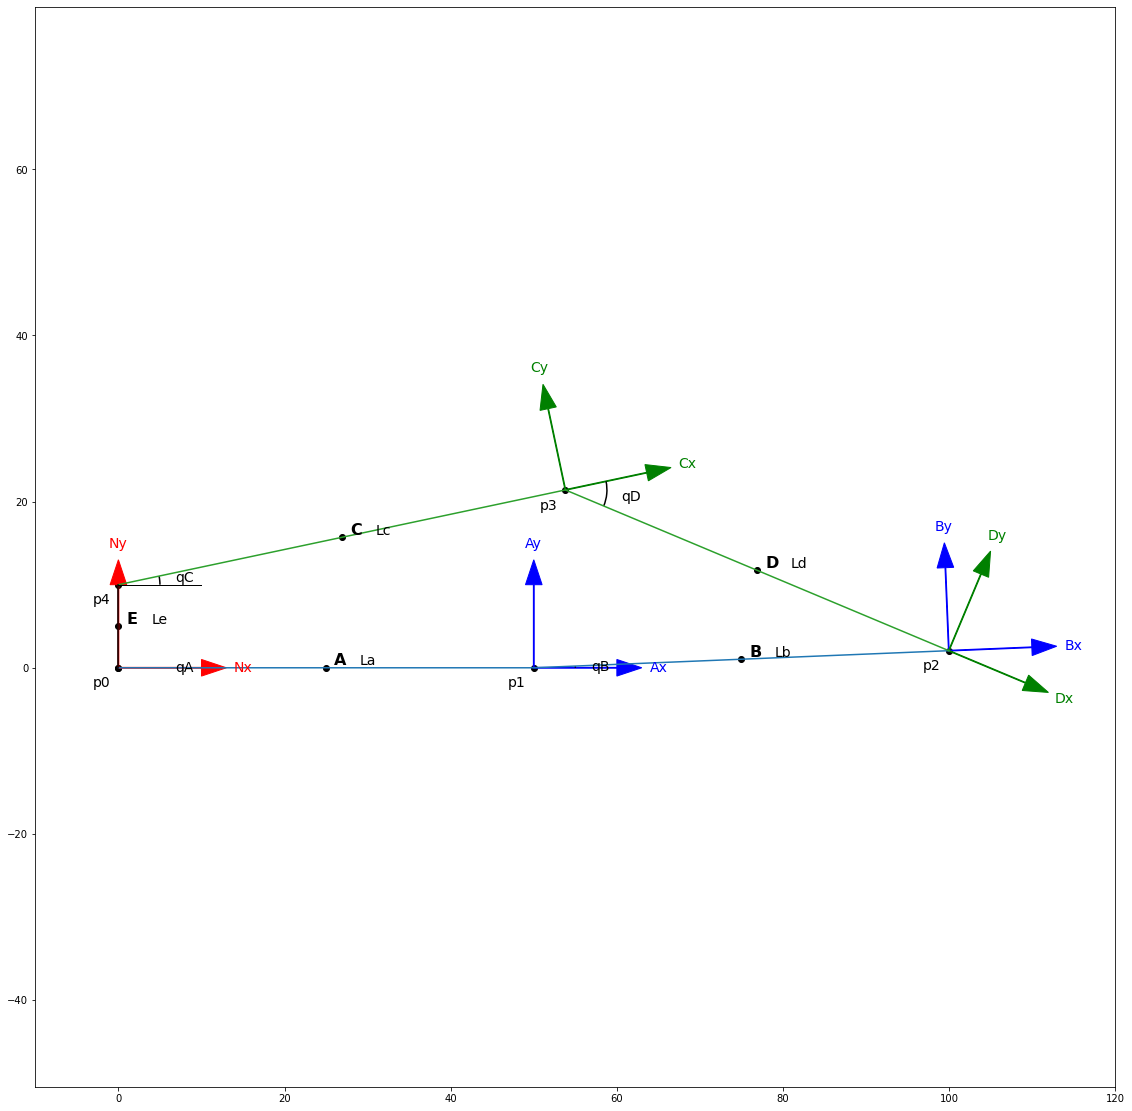

In [32]:
# Valid initial condition
x = numpy.array([points.y[1][0][0], points.y[1][1][0], points.y[1][2][0], points.y[1][3][0], points.y[1][4][0],0])*1000
y = numpy.array([points.y[1][0][1], points.y[1][1][1], points.y[1][2][1], points.y[1][3][1], points.y[1][4][1],0])*1000
prettyplot(x,y)

## 6. Define Force Vectors
From your biomechanics-based specifications, define one or more force vector estimates (one for each end effector) that the system should be expected to experience. Consider including, based on your research

1. the force of gravity exerted by the mass of a “payload” or the main body of the robot.

2. the acceleration the system experiences during a typical gait
    
3. ground reaction forces measured from biomechanics studies.

In [33]:
# End effector force
Fend_num = numpy.array([0, -2.4*9.81/2]).reshape([2,1])
Fend_num

array([[  0.   ],
       [-11.772]])

In [34]:
# End effector velocity
vend_num = numpy.array([0, -10]).reshape([2,1])
vend_num

array([[  0],
       [-10]])

## 7. Calculate Input Forces

Calculate the force or torque required at the input to satisfy the end-effector force requirements

In [35]:
# Input force symbolic
Fin = sympy.Matrix(J.transpose()*Fend_num)
Fin

⎡-11.772⋅lA⋅sin(qB)⋅cos(qC + qD) ⎤
⎢────────────────────────────────⎥
⎢     sin(qA + qB - qC - qD)     ⎥
⎢                                ⎥
⎢ 11.772⋅lC⋅sin(qD)⋅cos(qA + qB) ⎥
⎢ ────────────────────────────── ⎥
⎣     sin(qA + qB - qC - qD)     ⎦

In [36]:
# Input force numeric
Fin_num = Fin.subs([(qA, ini[0]),(qB, ini[1]),(qC, ini[2]),(qD, ini[3]),(lA, lA_num),(lB, lB_num),(lC, lC_num),(lD, lD_num)])
Fin_num

⎡-0.0525983520885805⎤
⎢                   ⎥
⎣-0.868230438139323 ⎦

## 8. Estimate End-Effector Velocity

Estimate the velocity of the end-effector in this configuration. Using the Jacobian, calculate the speed required by the input(s) to achieve that output motion.

This may not be directly solvable based on your device kinematics; an iterative guess-and-check approach is ok.

In [37]:
# Input velocity symbolic
vin = sympy.Matrix(J.inv()*vend_num)
vin

⎡                   10⋅sin(qA + qB)⋅sin(qA + qB - qC - qD)                   ⎤
⎢────────────────────────────────────────────────────────────────────────────⎥
⎢-lA⋅sin(qB)⋅sin(qA + qB)⋅cos(qC + qD) + lA⋅sin(qB)⋅sin(qC + qD)⋅cos(qA + qB)⎥
⎢                                                                            ⎥
⎢                   10⋅sin(qC + qD)⋅sin(qA + qB - qC - qD)                   ⎥
⎢────────────────────────────────────────────────────────────────────────────⎥
⎣-lC⋅sin(qD)⋅sin(qA + qB)⋅cos(qC + qD) + lC⋅sin(qD)⋅sin(qC + qD)⋅cos(qA + qB)⎦

In [38]:
# Input velocity numeric
vin_num = vin.subs([(qA, ini[0]),(qB, ini[1]),(qC, ini[2]),(qD, ini[3]),(lA, lA_num),(lB, lB_num),(lC, lC_num),(lD, lD_num)])
vin_num

⎡     -200.0      ⎤
⎢                 ⎥
⎣-123.469904846945⎦

## 9. Compute Required Power

Finally, using the two estimates about force and speed at the input, compute the required power in this configuration.

In [39]:
# Input power symbolic
Pin = sympy.Matrix([[Fin[0]*vin[0]],[Fin[1]*vin[1]]])
Pin

⎡               -117.72⋅lA⋅sin(qB)⋅sin(qA + qB)⋅cos(qC + qD)                 ⎤
⎢────────────────────────────────────────────────────────────────────────────⎥
⎢-lA⋅sin(qB)⋅sin(qA + qB)⋅cos(qC + qD) + lA⋅sin(qB)⋅sin(qC + qD)⋅cos(qA + qB)⎥
⎢                                                                            ⎥
⎢                117.72⋅lC⋅sin(qD)⋅sin(qC + qD)⋅cos(qA + qB)                 ⎥
⎢────────────────────────────────────────────────────────────────────────────⎥
⎣-lC⋅sin(qD)⋅sin(qA + qB)⋅cos(qC + qD) + lC⋅sin(qD)⋅sin(qC + qD)⋅cos(qA + qB)⎦

In [40]:
# Input power numeric
Pin_num = Pin.subs([(qA, ini[0]),(qB, ini[1]),(qC, ini[2]),(qD, ini[3]),(lA, lA_num),(lB, lB_num),(lC, lC_num),(lD, lD_num)])
Pin_num

⎡10.5196704177161⎤
⎢                ⎥
⎣107.200329582284⎦

# Discussion

1. How many degrees of freedom does your device have? How many motors? If the answer is not the same, what determines the state of the remaining degrees of freedom? How did you arrive at that number?

...

2. If your mechanism has more than one degree of freedom, please describe how those multiple degrees of freedom will work togehter to create a locomotory gait or useful motion. What is your plan for synchonizing, especially if passive energy storage?

...

3. How did you estimate your expected end-effector forces

Migratory bird: Canada Goose https://en.wikipedia.org/wiki/Canada_goose

min mass: 2.4kg

min wing span: 127cm

min wing chord: 39cm

half weight = 2.4x9.81/2

...

4. How did you estimate your expected end-effector speeds

...

# References